**Chapter 2 – End-to-end Machine Learning project**

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

*This notebook contains all the sample code and solutions to the exercices in chapter 2.*

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Get the data

In [2]:
import os
import zipfile
import urllib

DOWNLOAD_ROOT = "https://github.com/aiforsec/RIT-DSCI-633-FDS/blob/main/Assignments/titanic.zip?raw=true"
TITANIC_PATH = os.path.join("datasets", "titanic")
TITANIC_URL = DOWNLOAD_ROOT 

def extract_titanic_data(titanic_url=TITANIC_URL,titanic_path=TITANIC_PATH):
    if not os.path.isdir(titanic_path):
        os.makedirs(titanic_path)
    zip_path = os.path.join(titanic_path,"titanic.zip")
    urllib.request.urlretrieve(titanic_url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(titanic_path)

In [3]:
extract_titanic_data()

In [4]:
import pandas as pd

def load_titanic_train_data(titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, "train.csv")
    return pd.read_csv(csv_path)
def load_titanic_test_data(titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, "test.csv")
    return pd.read_csv(csv_path)
def load_titanic_gender_submission_data(titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, "gender_submission.csv")
    return pd.read_csv(csv_path)

### Loading training dataset

In [5]:
titanicTrain = load_titanic_train_data()
titanicTrain.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Loading and merging test dataset

In [6]:
# Merging two dataframe to complete test dataset
titanicTest = load_titanic_test_data()
titanicGenderSubmission = load_titanic_gender_submission_data()

titanicTestMerged = pd.merge(left = titanicTest, right = titanicGenderSubmission, on = 'PassengerId')
# labels for test data
titanicTestMerged_labels = titanicTestMerged["Survived"].copy()
# features for test data without label and other attributes that is not required
titanicTestMergedTrimmed = titanicTestMerged.drop(["Survived"], axis=1)

In [7]:
titanicTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
titanicTrain["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [9]:
titanicTrain.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Saving figure attribute_histogram_plots


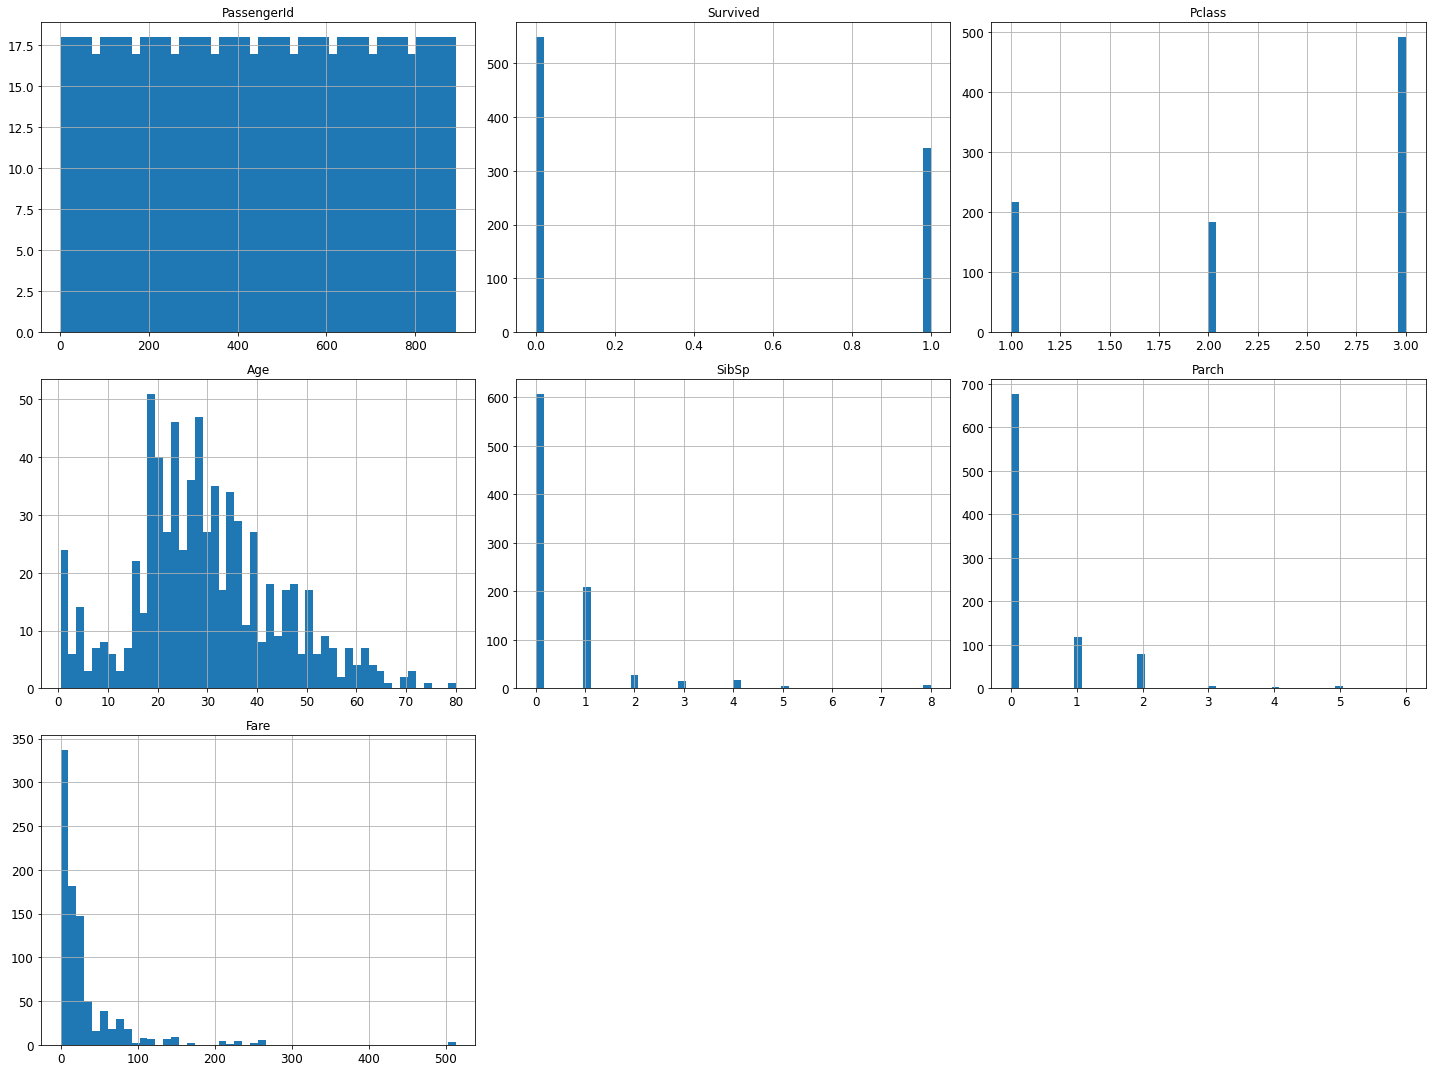

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
titanicTrain.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

# Discover and visualize the data to gain insights

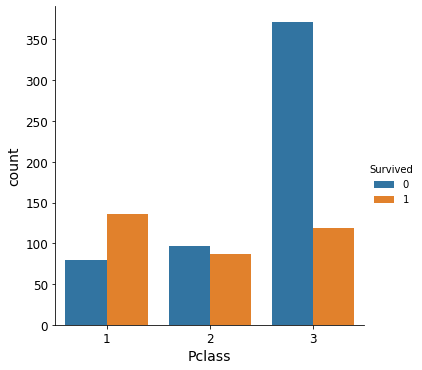

In [11]:
import seaborn as sns
sns.catplot(x='Pclass',data=titanicTrain,hue='Survived',kind='count')

# Prepare the data for Machine Learning algorithms

In [12]:

titanicTrain_labels = titanicTrain["Survived"].copy()
titanicTrain = titanicTrain.drop("Survived", axis=1)
titanicTrain.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
sample_incomplete_rows = titanicTrain[titanicTrain.isnull().any(axis=1)].head()
sample_incomplete_rows

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


In [14]:
sample_incomplete_rows.dropna(subset=["Cabin"])    # option 1

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [15]:
sample_incomplete_rows.drop("Cabin", axis=1)       # option 2

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,Q
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S


In [16]:
median = titanicTrain["Age"].median()
sample_incomplete_rows["Age"].fillna(median, inplace=True) # option 3

In [17]:
sample_incomplete_rows

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,NaN,Q
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


In [18]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [19]:
titanicTrain_num = titanicTrain.drop(["Cabin","Name","Ticket","Sex","Embarked"], axis=1)

In [20]:
imputer.fit(titanicTrain_num)

SimpleImputer(strategy='median')

In [21]:
imputer.statistics_

array([446.    ,   3.    ,  28.    ,   0.    ,   0.    ,  14.4542])

Check that this is the same as manually computing the median of each attribute:

In [22]:
titanicTrain_num.median().values

array([446.    ,   3.    ,  28.    ,   0.    ,   0.    ,  14.4542])

Transform the training set:

In [23]:
X = imputer.transform(titanicTrain_num)

In [24]:
titanicTrain_tr = pd.DataFrame(X, columns=titanicTrain_num.columns,
                          index=titanicTrain.index)

In [25]:
titanicTrain_tr.loc[sample_incomplete_rows.index.values]
sample_incomplete_rows.index

Int64Index([0, 2, 4, 5, 7], dtype='int64')

In [26]:
imputer.strategy

'median'

In [27]:
titanicTrain_tr = pd.DataFrame(X, columns=titanicTrain_num.columns,
                          index=titanicTrain_num.index)

In [28]:
titanicTrain_tr.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,1.0,3.0,22.0,1.0,0.0,7.2500
1,2.0,1.0,38.0,1.0,0.0,71.2833
2,3.0,3.0,26.0,0.0,0.0,7.9250
3,4.0,1.0,35.0,1.0,0.0,53.1000
4,5.0,3.0,35.0,0.0,0.0,8.0500


Now let's preprocess the categorical input feature, `ocean_proximity`:

In [29]:
titanicTrain_cat = titanicTrain[["Sex","Embarked"]]

catImputer = SimpleImputer(strategy="most_frequent")
catImputer.fit(titanicTrain_cat)
titanicTrain_cat = catImputer.transform(titanicTrain_cat)

In [30]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
titanicTrain_cat_encoded = ordinal_encoder.fit_transform(titanicTrain_cat)
titanicTrain_cat_encoded[:10]

array([[1., 2.],
       [0., 0.],
       [0., 2.],
       [0., 2.],
       [1., 2.],
       [1., 1.],
       [1., 2.],
       [1., 2.],
       [0., 2.],
       [0., 0.]])

In [31]:
ordinal_encoder.categories_

[array(['female', 'male'], dtype=object), array(['C', 'Q', 'S'], dtype=object)]

In [32]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
titanicTrain_cat_1hot = cat_encoder.fit_transform(titanicTrain_cat)
titanicTrain_cat_1hot

<891x5 sparse matrix of type '<class 'numpy.float64'>'
	with 1782 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [33]:
titanicTrain_cat_1hot.toarray()

array([[0., 1., 0., 0., 1.],
       [1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0.],
       [0., 1., 0., 1., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [34]:
cat_encoder = OneHotEncoder(sparse=False)
titanicTrain_cat_1hot = cat_encoder.fit_transform(titanicTrain_cat)
titanicTrain_cat_1hot

array([[0., 1., 0., 0., 1.],
       [1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0.],
       [0., 1., 0., 1., 0.]])

In [35]:
cat_encoder.categories_

[array(['female', 'male'], dtype=object), array(['C', 'Q', 'S'], dtype=object)]

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

titanicTrain_num_tr = num_pipeline.fit_transform(titanicTrain_num)

In [37]:
titanicTrain_num_tr

array([[-1.73010796,  0.82737724, -0.56573646,  0.43279337, -0.47367361,
        -0.50244517],
       [-1.72622007, -1.56610693,  0.66386103,  0.43279337, -0.47367361,
         0.78684529],
       [-1.72233219,  0.82737724, -0.25833709, -0.4745452 , -0.47367361,
        -0.48885426],
       ...,
       [ 1.72233219,  0.82737724, -0.1046374 ,  0.43279337,  2.00893337,
        -0.17626324],
       [ 1.72622007, -1.56610693, -0.25833709, -0.4745452 , -0.47367361,
        -0.04438104],
       [ 1.73010796,  0.82737724,  0.20276197, -0.4745452 , -0.47367361,
        -0.49237783]])

In [38]:
from sklearn.compose import ColumnTransformer

num_attribs = list(titanicTrain_num)
cat_attribs = ["Sex","Embarked"]

full_pipeline = ColumnTransformer([
        ("dropcolumns", 'drop',["Cabin","Name","Ticket"]),
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

#titanicTrain_trimmed = titanicTrain.drop(["Cabin","Name","Ticket"], axis=1)

titanicTrain_prepared = full_pipeline.fit_transform(titanicTrain)
print(num_attribs)
print(cat_attribs)

['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
['Sex', 'Embarked']


In [39]:
titanicTrain_prepared

array([[-1.73010796,  0.82737724, -0.56573646, ...,  0.        ,
         1.        ,  0.        ],
       [-1.72622007, -1.56610693,  0.66386103, ...,  0.        ,
         0.        ,  0.        ],
       [-1.72233219,  0.82737724, -0.25833709, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.72233219,  0.82737724, -0.1046374 , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.72622007, -1.56610693, -0.25833709, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.73010796,  0.82737724,  0.20276197, ...,  1.        ,
         0.        ,  0.        ]])

In [40]:
titanicTrain_prepared.shape

(891, 12)

# Select and train a model 

## Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(titanicTrain_prepared, titanicTrain_labels)

train_pred = log_reg.predict(titanicTrain_prepared)

Text(0.5, 1.0, 'Confusion Matrix')

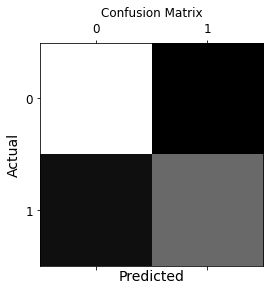

In [42]:
from sklearn.metrics import confusion_matrix
conf_lr = confusion_matrix(titanicTrain_labels, train_pred)
plt.matshow(conf_lr, cmap=plt.cm.gray)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

In [43]:
from sklearn.metrics import accuracy_score
accuracy_score(titanicTrain_labels, train_pred)

0.8002244668911336

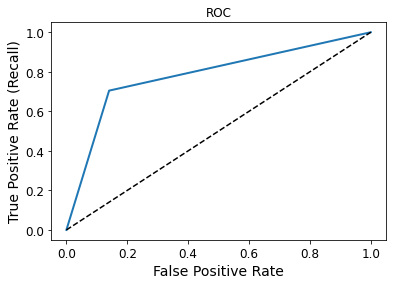

In [44]:
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(titanicTrain_labels, train_pred)
def plot_roc(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC")
plot_roc(fpr, tpr)

In [45]:
# titanicTestMerged.head()
# titanicTestMerged_labels = titanicTestMerged["Survived"].copy()
# titanicTestMergedTrimmed = titanicTestMerged.drop(["Cabin","Name","Ticket","Survived"], axis=1)
# titanicTestMerged_prepared = full_pipeline.transform(titanicTestMergedTrimmed)

# test_pred = log_reg.predict(titanicTestMerged_prepared)
# confusion_matrix(titanicTestMerged_labels, test_pred)

# fprt, tprt, thresholdtest = roc_curve(titanicTestMerged_labels, test_pred)

# plot_roc(fprt, tprt)
# plt.show()
# accuracy_score(titanicTestMerged_labels, test_pred)

## Naive Bayes

Text(0.5, 1.0, 'Confusion Matrix')

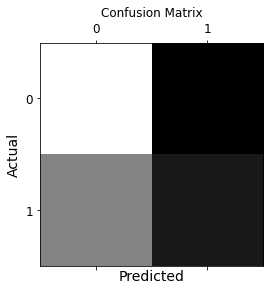

In [46]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(titanicTrain_prepared, titanicTrain_labels)
train_nb_pred = nb.predict(titanicTrain_prepared)

conf_nb = confusion_matrix(titanicTrain_labels, train_nb_pred)
plt.matshow(conf_nb, cmap=plt.cm.gray)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

In [47]:
accuracy_score(titanicTrain_labels, train_nb_pred)

0.6722783389450057

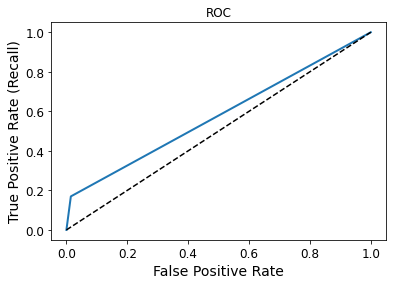

In [48]:
fpr_nb, tpr_nb, thresholdtest_nb = roc_curve(titanicTrain_labels, train_nb_pred)
plot_roc(fpr_nb, tpr_nb)
plt.show()

## Stochastic Gradient Descent

Text(0.5, 1.0, 'Confusion Matrix')

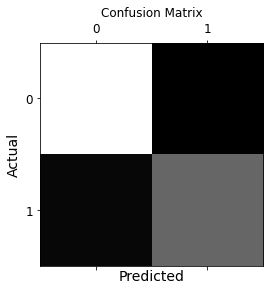

In [49]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(random_state=42)
sgd.fit(titanicTrain_prepared, titanicTrain_labels)
train_sgd_pred = sgd.predict(titanicTrain_prepared)

conf_sgd = confusion_matrix(titanicTrain_labels, train_sgd_pred)
plt.matshow(conf_sgd, cmap=plt.cm.gray)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

In [50]:
accuracy_score(titanicTrain_labels, train_sgd_pred)

0.7789001122334456

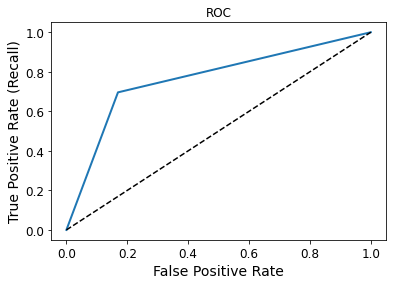

In [51]:
fpr_sgd, tpr_sgd, thresholdtest_sgd = roc_curve(titanicTrain_labels, train_sgd_pred)
plot_roc(fpr_sgd, tpr_sgd)
plt.show()

# Fine-tune your model

## Logistic Regression

In [52]:
from sklearn.model_selection import cross_val_score

scores_lg = cross_val_score(log_reg, titanicTrain_prepared, titanicTrain_labels,
                         scoring="accuracy", cv=10)
print("Scores:", scores_lg)
print("Mean:", scores_lg.mean())
print("Standard deviation:", scores_lg.std())

Scores: [0.78888889 0.79775281 0.76404494 0.80898876 0.78651685 0.76404494
 0.78651685 0.78651685 0.79775281 0.83146067]
Mean: 0.7912484394506866
Standard deviation: 0.018892189167530396


## Naive Bayes

In [53]:
from sklearn.model_selection import cross_val_score

scores_nb = cross_val_score(nb, titanicTrain_prepared, titanicTrain_labels,
                         scoring="accuracy", cv=10)
print("Scores:", scores_nb)
print("Mean:", scores_nb.mean())
print("Standard deviation:", scores_nb.std())

Scores: [0.64444444 0.64044944 0.68539326 0.76404494 0.6741573  0.62921348
 0.65168539 0.6741573  0.70786517 0.66292135]
Mean: 0.6734332084893881
Standard deviation: 0.03742628247388615


## Stochastic Gradient Descent

In [54]:
from sklearn.model_selection import cross_val_score

scores_sgd = cross_val_score(sgd, titanicTrain_prepared, titanicTrain_labels,
                         scoring="accuracy", cv=10)
print("Scores:", scores_sgd)
print("Mean:", scores_sgd.mean())
print("Standard deviation:", scores_sgd.std())

Scores: [0.84444444 0.79775281 0.76404494 0.83146067 0.79775281 0.7752809
 0.76404494 0.75280899 0.7752809  0.82022472]
Mean: 0.7923096129837702
Standard deviation: 0.029710928503473955


In [55]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'], 
     'learning_rate': ['constant', 'invscaling', 'optimal', 'adaptive'],
    'penalty': ['l2','l1','elasticnet'],
    'eta0': [0.00001]}
  ]
 
grid_search = GridSearchCV(sgd, param_grid, cv=5,
                           scoring='accuracy',
                           return_train_score=True)
grid_search.fit(titanicTrain_prepared, titanicTrain_labels)

GridSearchCV(cv=5, estimator=SGDClassifier(random_state=42),
             param_grid=[{'eta0': [1e-05],
                          'learning_rate': ['constant', 'invscaling', 'optimal',
                                            'adaptive'],
                          'loss': ['hinge', 'log', 'modified_huber',
                                   'squared_hinge', 'perceptron'],
                          'penalty': ['l2', 'l1', 'elasticnet']}],
             return_train_score=True, scoring='accuracy')

The best hyperparameter combination found:

In [56]:
grid_search.best_params_

{'eta0': 1e-05, 'learning_rate': 'optimal', 'loss': 'hinge', 'penalty': 'l1'}

In [57]:
grid_search.best_estimator_

SGDClassifier(eta0=1e-05, penalty='l1', random_state=42)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [58]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.7161195154102065 {'eta0': 1e-05, 'learning_rate': 'constant', 'loss': 'hinge', 'penalty': 'l2'}
0.7161195154102065 {'eta0': 1e-05, 'learning_rate': 'constant', 'loss': 'hinge', 'penalty': 'l1'}
0.7161195154102065 {'eta0': 1e-05, 'learning_rate': 'constant', 'loss': 'hinge', 'penalty': 'elasticnet'}
0.7183729834913063 {'eta0': 1e-05, 'learning_rate': 'constant', 'loss': 'log', 'penalty': 'l2'}
0.7183729834913063 {'eta0': 1e-05, 'learning_rate': 'constant', 'loss': 'log', 'penalty': 'l1'}
0.7183729834913063 {'eta0': 1e-05, 'learning_rate': 'constant', 'loss': 'log', 'penalty': 'elasticnet'}
0.7767371790848033 {'eta0': 1e-05, 'learning_rate': 'constant', 'loss': 'modified_huber', 'penalty': 'l2'}
0.7767371790848033 {'eta0': 1e-05, 'learning_rate': 'constant', 'loss': 'modified_huber', 'penalty': 'l1'}
0.7767371790848033 {'eta0': 1e-05, 'learning_rate': 'constant', 'loss': 'modified_huber', 'penalty': 'elasticnet'}
0.7767371790848033 {'eta0': 1e-05, 'learning_rate': 'constant', 'loss': '

In [59]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta0,param_learning_rate,param_loss,param_penalty,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.006402,3.216919e-03,0.002400,0.001960,0.00001,constant,hinge,l2,"{'eta0': 1e-05, 'learning_rate': 'constant', '...",0.653631,...,0.716120,0.040776,49,0.737360,0.713885,0.723703,0.729313,0.713885,0.723629,0.009063
1,0.008802,1.600409e-03,0.000000,0.000000,0.00001,constant,hinge,l1,"{'eta0': 1e-05, 'learning_rate': 'constant', '...",0.653631,...,0.716120,0.040776,49,0.737360,0.713885,0.723703,0.729313,0.713885,0.723629,0.009063
2,0.009856,1.813287e-03,0.000803,0.001605,0.00001,constant,hinge,elasticnet,"{'eta0': 1e-05, 'learning_rate': 'constant', '...",0.653631,...,0.716120,0.040776,49,0.737360,0.713885,0.723703,0.729313,0.713885,0.723629,0.009063
3,0.000800,1.600456e-03,0.000800,0.001600,0.00001,constant,log,l2,"{'eta0': 1e-05, 'learning_rate': 'constant', '...",0.648045,...,0.718373,0.043071,43,0.731742,0.713885,0.720898,0.730715,0.711080,0.721664,0.008445
4,0.003201,1.600432e-03,0.000000,0.000000,0.00001,constant,log,l1,"{'eta0': 1e-05, 'learning_rate': 'constant', '...",0.648045,...,0.718373,0.043071,43,0.731742,0.713885,0.720898,0.730715,0.711080,0.721664,0.008445
5,0.000800,1.600361e-03,0.000000,0.000000,0.00001,constant,log,elasticnet,"{'eta0': 1e-05, 'learning_rate': 'constant', '...",0.648045,...,0.718373,0.043071,43,0.731742,0.713885,0.720898,0.730715,0.711080,0.721664,0.008445
6,0.004801,1.600385e-03,0.000000,0.000000,0.00001,constant,modified_huber,l2,"{'eta0': 1e-05, 'learning_rate': 'constant', '...",0.703911,...,0.776737,0.043156,2,0.790730,0.788219,0.785414,0.799439,0.778401,0.788441,0.006873
7,0.006367,1.934645e-03,0.000000,0.000000,0.00001,constant,modified_huber,l1,"{'eta0': 1e-05, 'learning_rate': 'constant', '...",0.703911,...,0.776737,0.043156,2,0.790730,0.788219,0.785414,0.799439,0.778401,0.788441,0.006873
8,0.007016,1.124969e-03,0.000000,0.000000,0.00001,constant,modified_huber,elasticnet,"{'eta0': 1e-05, 'learning_rate': 'constant', '...",0.703911,...,0.776737,0.043156,2,0.790730,0.788219,0.785414,0.799439,0.778401,0.788441,0.006873
9,0.004204,2.224031e-03,0.000000,0.000000,0.00001,constant,squared_hinge,l2,"{'eta0': 1e-05, 'learning_rate': 'constant', '...",0.703911,...,0.776737,0.043156,2,0.790730,0.788219,0.785414,0.799439,0.778401,0.788441,0.006873


# Accuracy on test set

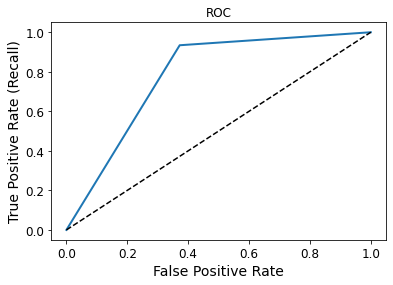

Accuracy on Test set:  73.92344497607655 %


In [60]:
final_model = grid_search.best_estimator_

# titanicTestMerged_labels = titanicTestMerged["Survived"].copy()
# titanicTestMergedTrimmed = titanicTestMerged.drop(["Cabin","Name","Ticket","Survived"], axis=1)
titanicTestMerged_prepared = full_pipeline.transform(titanicTestMergedTrimmed)

final_predictions = final_model.predict(titanicTestMerged_prepared)
confusion_matrix(titanicTestMerged_labels, final_predictions)

fpr_fm, tpr_fm, threshold_fm = roc_curve(titanicTestMerged_labels, final_predictions)

plot_roc(fpr_fm, tpr_fm)
plt.show()
print("Accuracy on Test set: ",accuracy_score(titanicTestMerged_labels, final_predictions)*100, "%")